# 03. Feature Analysis

Given a specific modeling approach, attempt to determine which features are attended for classification results. Additionally, attempt to obtain Shapley values for the features and present on a figure.


In [1]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    print("Load Data")
data_df.head()

Subject_ID Diagnosis Study  \
0       4225        HC  MUSC   
1       5018       NEG  MUSC   
2       4153        HC  ADNI   
3       4192        HC  MUSC   
4       4546        HC  MUSC   

                                                Data   Age Sex Site  \
0  [[70.00010837, 53.02759354, -53.81089108, -6.2...  77.0   M  002   
1  [[-27.97690796, -5.066491721, -3.921456223, 2....  74.0   M  002   
2  [[13.47474791, 13.11261372, 31.21361533, -18.9...  80.0   M  006   
3  [[-10.20236626, -34.17503708, -0.8613294553, -...  83.0   M  006   
4  [[14.13224781, -72.02016385, -17.840065, -5.84...  72.0   M  006   

                                          Connectome  \
0  [[0.0, -0.12854080002335547, -0.02947760712390...   
1  [[0.0, -0.026148340454320303, 0.02084422397087...   
2  [[0.0, -0.07499495678945452, 0.000609714196664...   
3  [[0.0, 0.011486552913473532, 0.012243779672988...   
4  [[0.0, -0.06363519615779353, -0.00996558955112...   

                                          Harmonized  \
0  [[0.0, -0.14521184882997326, -0.03614492450752...   
1  [[0.0, -0.047165758247266654, 0.02154247724724...   
2  [[0.0, -0.10168881215260582, 0.004797680065067...   
3  [[0.0, -0.00196764312401404, 0.018479481403202...   
4  [[0.0, -0.08727172387777749, -0.00765154703518...   

                                                 EVC  \
0  [0.026392520367547665, 0.04784496122360292, 0....   
1  [0.04356351850526411, 0.02501455841636518, 0.0...   
2  [0.03200834019543967, 0.07978198467710379, 0.0...   
3  [0.0008345559255547103, 0.005052810068538203, ...   
4  [0.013189710375477578, 0.011222072503586313, 0...   

                                                 CLU  \
0  [0.007048212767037088, 0.008029111424058103, 0...   
1  [0.007718426189211259, 0.008243840720672104, 0...   
2  [0.00959188463311402, 0.009881226310982079, 0....   
3  [0.006808899862500481, 0.008036275731763054, 0...   
4  [0.0057135772952840195, 0.0063225380077960615,...   

                                                 DIV  
0  [0.9730236264352107, 0.9648008208169985, 0.969...  
1  [0.9893545442055375, 0.9925977430615308, 0.976...  
2  [0.9691352495448783, 0.9629159581883214, 0.964...  
3  [0.9710467849567415, 0.9530865783648983, 0.953...  
4  [0.9710519435179967, 0.9808040985845641, 0.951...

In [2]:
ad_df = data_df[(data_df["Study"] != "TBI") & (data_df["Harmonized"].notna())]
ad_evc = np.vstack(ad_df["EVC"])
ad_class = np.where(ad_df["Diagnosis"] == "AD", 1, 0)

In [3]:
state = 100

clf = svm.SVC(
    kernel="sigmoid", class_weight="balanced", probability=True, random_state=state
)

scaler = StandardScaler()
ad_evc_scaled = scaler.fit_transform(ad_evc)

x_train, x_test, y_train, y_test = train_test_split(
    ad_evc_scaled, ad_class, random_state=state, stratify=ad_class
)
feature_variance = pd.DataFrame(x_train).var(axis=0)
print("Feature Variance:\n", feature_variance)
clf.fit(x_train, y_train)
# best_model = clf

Feature Variance:
 0      0.893943
1      1.171880
2      1.143255
3      0.981148
4      1.038980
         ...   
266    0.726206
267    1.094725
268    1.096638
269    1.097456
270    1.162907
Length: 271, dtype: float64


SVC(class_weight='balanced', kernel='sigmoid', probability=True,
    random_state=100)

In [4]:
svc_params = {
    "C": np.linspace(0.1, 10, 25),
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": np.logspace(1e-10, 1, 10),
}

gridsearch = GridSearchCV(
    estimator=clf,
    param_grid=svc_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=state),
    refit=True,
)
gridsearch.fit(x_train, y_train)
best_model = gridsearch.best_estimator_

In [5]:
explainer = shap.KernelExplainer(best_model.predict_proba, x_train)
shap_values = explainer.shap_values(x_test)
shap_pos_class = shap_values[:, :, 1]
shap_values_pos = shap.Explanation(
    values=shap_pos_class,
    base_values=explainer.expected_value[1],
    data=x_test,
    feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
)

Using 273 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/92 [00:00<?, ?it/s]

Best Model Parameters: {'C': np.float64(0.1), 'gamma': np.float64(1.0000000002302585), 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.46      1.00      0.63        42

    accuracy                           0.46        92
   macro avg       0.23      0.50      0.31        92
weighted avg       0.21      0.46      0.29        92

Confusion Matrix:
 [[ 0 50]
 [ 0 42]]


c:\Users\Konnor\Documents\Local\Files\Academic\Research\BrainConnectivity\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Konnor\Documents\Local\Files\Academic\Research\BrainConnectivity\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Konnor\Documents\Local\Files\Academic\Research\BrainConnectivity\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

Feature Importances:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


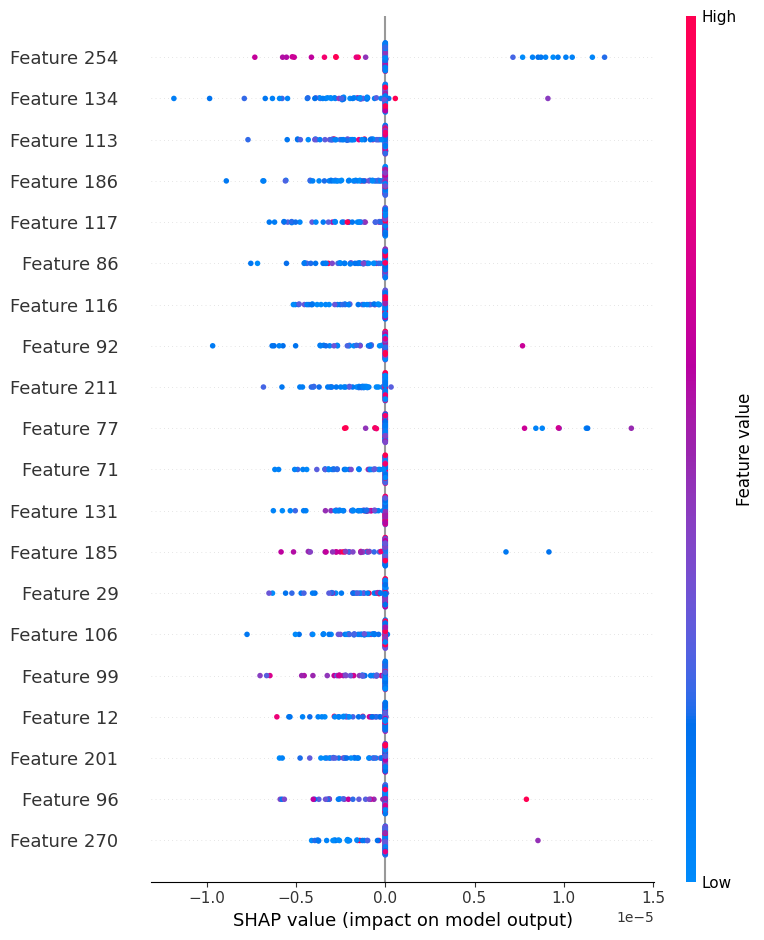

In [6]:
print("Best Model Parameters:", gridsearch.best_params_)

y_predict = best_model.predict(x_test)
print(classification_report(y_test, y_predict))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predict))

importances = permutation_importance(best_model, x_test, y_test, scoring="accuracy")
print("Feature Importances:\n", importances.importances_mean)

shap.summary_plot(
    shap_pos_class,
    x_test,
    feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
)

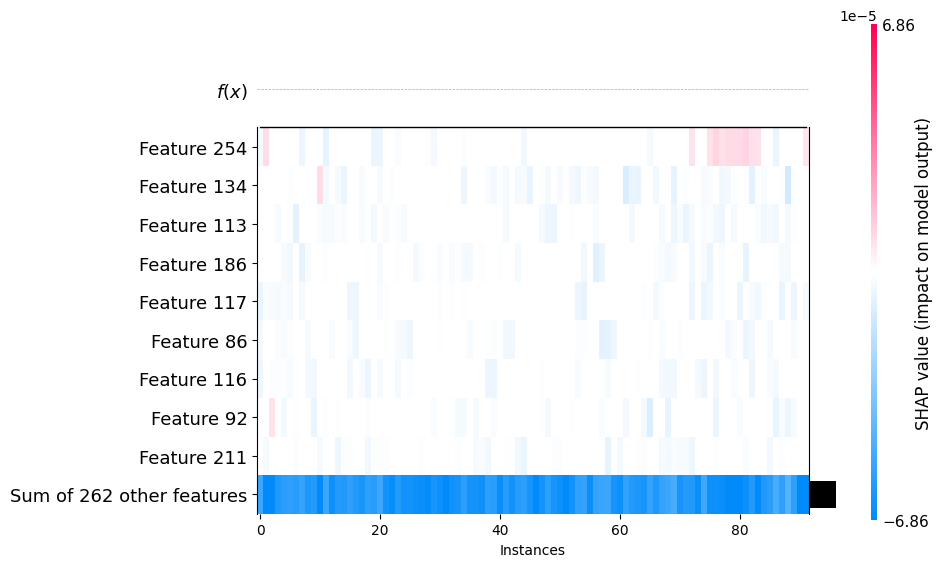

<Axes: xlabel='Instances'>

In [7]:
shap.plots.heatmap(shap_values_pos)

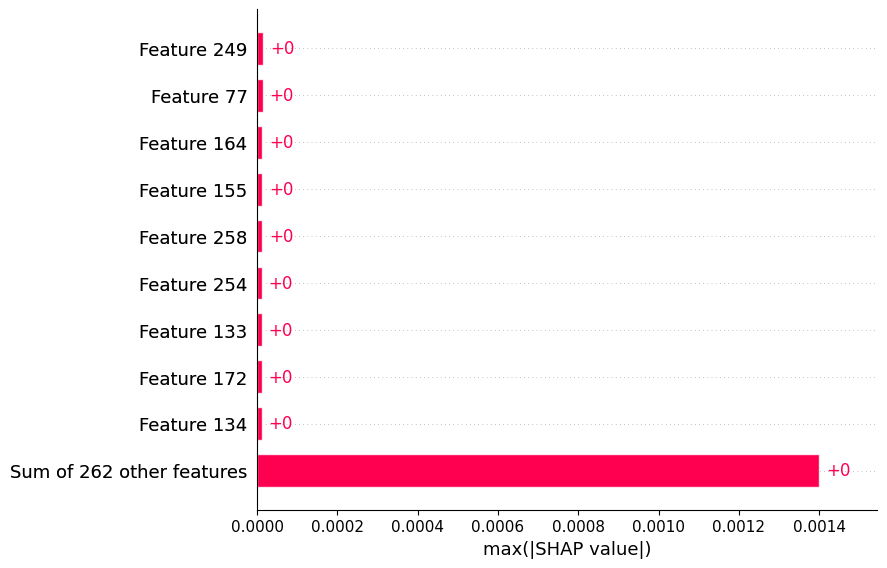

In [8]:
shap.plots.bar(shap_values_pos.abs.max(0))

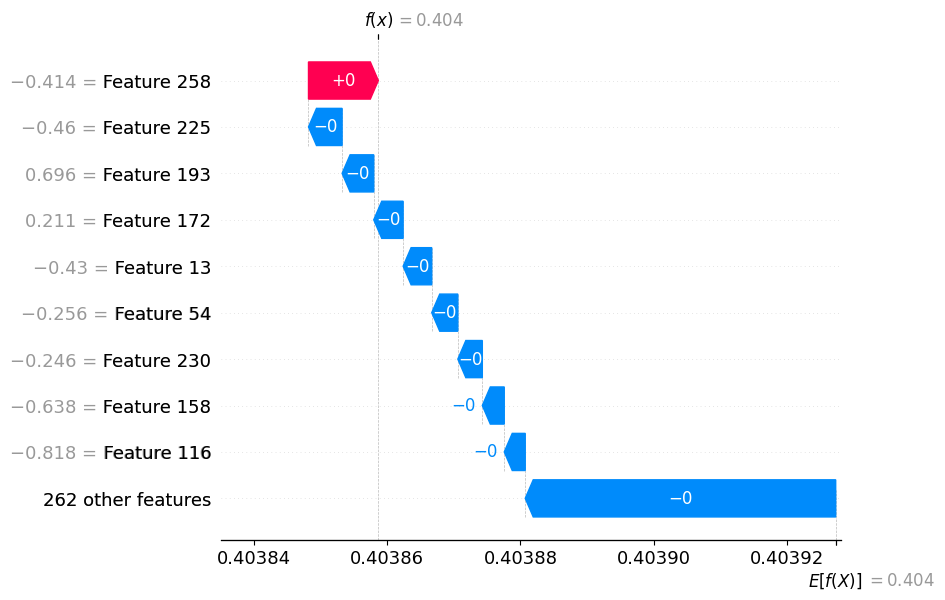

In [9]:
# Waterfall plots display individual predictions, so they expect a single row
# of an Explanation object as input
sample_ind = 0
shap.waterfall_plot(
    shap.Explanation(
        values=shap_pos_class[sample_ind],
        base_values=explainer.expected_value[1],
        data=x_test[sample_ind],
        feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
    )
)

### LASSO


In [10]:
from sklearn.linear_model import Lasso, lasso_path, LassoCV
from sklearn.metrics import mean_squared_error

reg = Lasso(alpha=1)
reg.fit(x_train, y_train)
print("R squared training set", round(reg.score(x_train, y_train) * 100, 2))
print("R squared test set", round(reg.score(x_test, y_test) * 100, 2))

# Training data
pred_train = reg.predict(x_train)
mse_train = mean_squared_error(y_train, pred_train)
print("MSE training set", round(mse_train, 2))

# Test data
pred = reg.predict(x_test)
mse_test = mean_squared_error(y_test, pred)
print("MSE test set", round(mse_test, 2))

R squared training set 0.0
R squared test set -0.01
MSE training set 0.25
MSE test set 0.25


Computing regularization path using the lasso...
Best alpha: 0.08011385213404154
R squared training set 0.0
R squared test set -0.01
MSE test: 0.24814530906265256


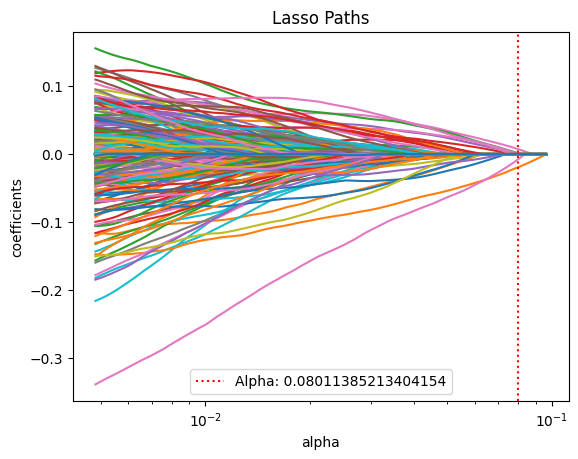

In [11]:
print("Computing regularization path using the lasso...")
eps = 5e-2
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train, eps=eps)

plt.figure(1)
for coef_lasso in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef_lasso)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
lasso_cv = LassoCV(cv=skf, random_state=state, max_iter=10000)
lasso_cv.fit(x_train, y_train)
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

plt.axvline(x=best_alpha, color="red", linestyle="dotted", label=f"Alpha: {best_alpha}")

lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(x_train, y_train)
coefficients = lasso_best.coef_
nonzero_indices = np.where(coefficients != 0)[0]

sorted_data = sorted(
    [
        (idx + 1, coef)
        for idx, coef in zip(nonzero_indices, coefficients[nonzero_indices])
    ],
    key=lambda x: abs(x[1]),
    reverse=True,
)
coefficients_df = pd.DataFrame(sorted_data, columns=["Feature Index", "Coefficient"])

print("R squared training set", round(lasso_best.score(x_train, y_train) * 100, 2))
print("R squared test set", round(lasso_best.score(x_test, y_test) * 100, 2))
print("MSE test:", mean_squared_error(y_test, lasso_best.predict(x_test)))

plt.legend()
plt.show()

(np.float64(5.6716263889068885e-05),
 np.float64(0.11316382398368967),
 np.float64(0.15011903656851677),
 np.float64(1.7050239293514202))

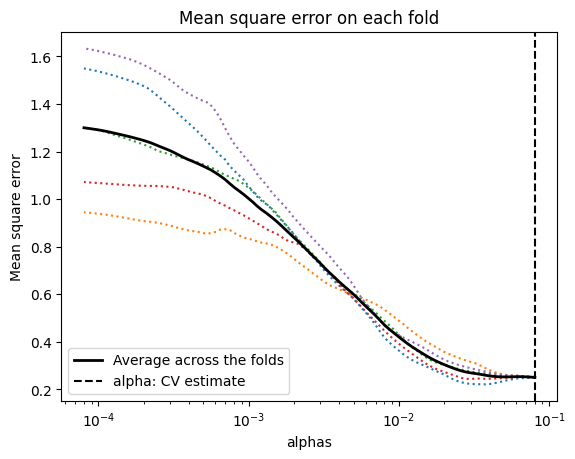

In [12]:
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, ":")
plt.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso_cv.alpha_, linestyle="--", color="k", label="alpha: CV estimate")

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 50000, 250000
# plt.ylim(ymin, ymax);

In [13]:
coefficients_df

Empty DataFrame
Columns: [Feature Index, Coefficient]
Index: []

In [14]:
from sklearn.feature_selection import f_regression

f_stat, p_values = f_regression(ad_evc_scaled, ad_class)
feature_data = pd.DataFrame(
    {"Feature Index": range(1, len(p_values) + 1), "P-Value": p_values}
)

significant_features = feature_data[feature_data["P-Value"] < 0.05].sort_values(
    by="P-Value"
)
significant_features

Feature Index   P-Value
224            225  0.004445
85              86  0.010215
210            211  0.026839
200            201  0.030158

In [15]:
# from pygam import LogisticGAM, s
# import scipy.sparse

# def to_array(self):
#     return self.toarray()

# scipy.sparse.spmatrix.A = property(to_array)

# np.int = np.int32
# np.float = np.float64
# np.bool = np.bool_
# x_t = pd.DataFrame(x_train)
# print(x_t)
# gam = LogisticGAM(verbose=True).fit(x_t, y_train)
# gam.summary()

In [16]:
# gam_opt = LogisticGAM().gridsearch(x_train, y_train)
# gam_opt.summary()

In [17]:
# pd.set_option('display.float_format', '{:.10f}'.format)
# feature_data.to_csv('out.csv')

### Apply to TBI Directly
Applies the grid-search model

In [ ]:
from sklearn.metrics import accuracy_score

tbi_df = data_df[data_df["Study"] == "TBI"]
tbi_evc = np.vstack(tbi_df["EVC"])
tbi_class = np.where(tbi_df["Diagnosis"] == "POS", 1, 0)
tbi_scaled = scaler.fit_transform(tbi_evc)

y_pred = best_model.predict(tbi_evc)
accuracy = accuracy_score(tbi_class, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(tbi_class, y_pred))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 271 and the array at index 14 has size 1

: 